<a href="https://www.kaggle.com/code/yujansaya/credit-card-fraud-detection?scriptVersionId=160394716" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1>Credit Card Fraud Detection</h1>
<br>
Let's try different ways to detect fraud transactions. In this notebook there are data preprocessing (**Feature Scaling, Over- and Undersampling such as SMOTE and Tomek Links**), ML classification algorithms (**Linear Regression, XGBoost, CatBoost** trees), **Neural Network** and **CNN**. Cost-sensitive learning also has been aplied in order to deal with imbalanced data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


The dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


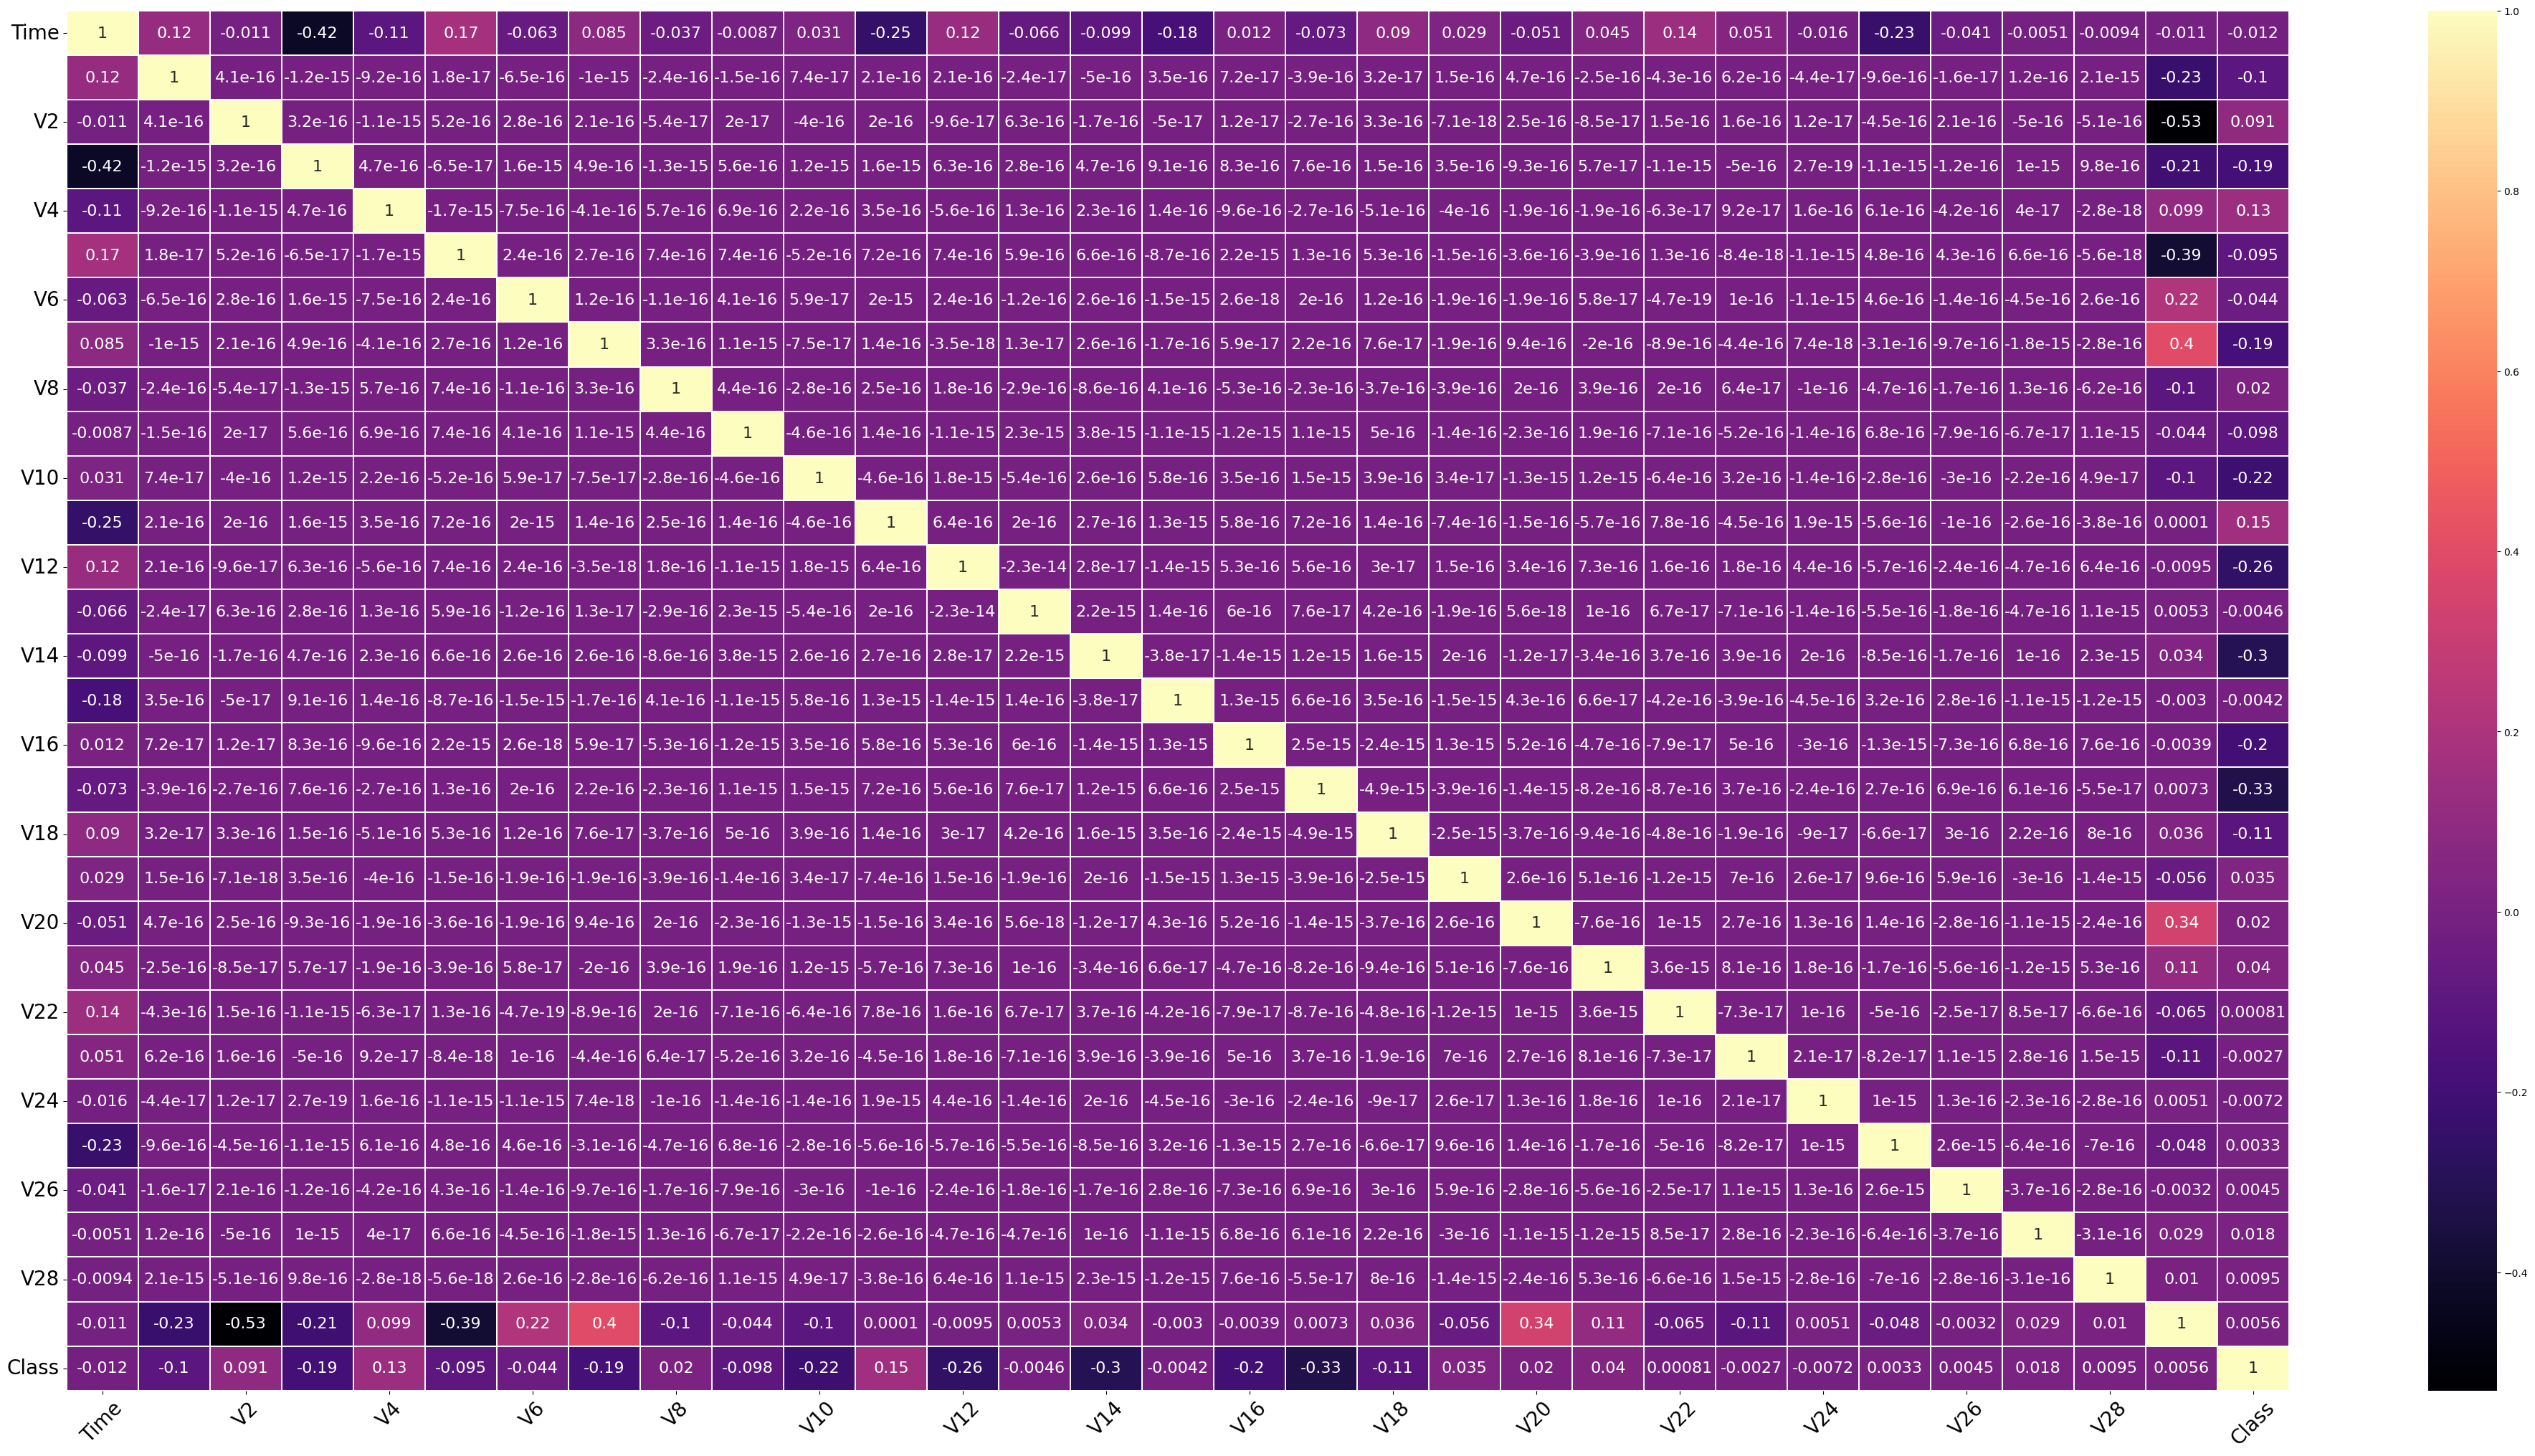

In [5]:
import seaborn as sns

'''Correlation Between The Features'''
sns.heatmap(df.corr(),annot=True,cmap='magma',linewidths=0.2, annot_kws={"size": 16})
fig=plt.gcf()
fig.set_size_inches(50,25)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.show() 

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Calculating the Imbalance Ratio (IR) for future tuning of cost-sensitive learning.**

In [7]:
perc = np.round(100 * df.Class.sum() / df.shape[0], 2 ) 
ir = perc / (100 - perc)
ir

0.0017028949213663228

**Preparing the train and test datasets.**

In [8]:
X = df.drop(columns = 'Class')
y = df['Class']

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [10]:
np.sum(y_test)

55

**Feature Scaling**

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Combined method of over- and undersampling in order to balance out the classes.**

In [12]:
# from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
# smote = SMOTE(sampling_strategy=0.1)

# autopct = "%.2f"
# #rus = RandomUnderSampler(sampling_strategy=0.5)
# tl = TomekLinks(sampling_strategy = 'majority')
# #oss = OneSidedSelection()

# steps = [('o', smote), ('u', tl)]
# pipeline = Pipeline(steps=steps)
# X_res, y_res = pipeline.fit_resample(X_train, y_train)

sampler = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), smote=SMOTE(sampling_strategy=0.1))
X_res, y_res = sampler.fit_resample(X_train, y_train)
# ax = y_res.value_counts().plot.pie(autopct=autopct)
# _ = ax.set_title("Under-sampling")

In [13]:
X_res.shape  

(281477, 30)

In [14]:
np.sum(y_res)  # number of fraudlent samples

25588

**Logistic Regression on rescaled data and original data with cost-sensitive learning.**

In [15]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_res, y_res)

LogisticRegression(random_state=0)

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, average_precision_score, roc_auc_score

In [17]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
accuracy_score(y_test, y_pred)

[[28378    48]
 [    7    48]]
0.8727272727272727
0.6357615894039735


0.9980688880306169

In [18]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_res, y = y_res, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 98.52 %
Standard Deviation: 0.06 %


In [19]:
classifier = LogisticRegression(C=1,class_weight={1:10},random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={1: 10}, random_state=0)

In [20]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Precision: {:.2f} %".format(precision_score(y_test, y_pred) * 100))
print("Recall: {:.2f} %".format(recall_score(y_test, y_pred) * 100))
print("F1: {:.2f} %".format(f1_score(y_test, y_pred) * 100))
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred) * 100))

[[28416    10]
 [    9    46]]
Precision: 82.14 %
Recall: 83.64 %
F1: 82.88 %
Accuracy: 99.93 %


In [21]:
aps = average_precision_score(y_test, y_pred)
aps

0.6873289871534315

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
parameters = [{'C':[1], 'random_state':[0],
              'class_weight':[{1: w} for w in [0.01,ir, 0.05, 0.1, 0.5, 1]]},
              ]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_res, y_res)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best Accuracy: 98.54 %
Best Parameters: {'C': 1, 'class_weight': {1: 0.5}, 'random_state': 0}


**XGBoost:** best results with the whole set of data and cost-sensitive learning (IR - imbalance rate). <br>
**Average Precision Score**: 72.62 %
<br><br>
**Precision**: 86.79 %
**Recall**: 83.64 %
**F1**: 85.19 %
**Accuracy**: 99.94 %

In [24]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100,
                                   max_depth=6,
                                   learning_rate=0.4,
                                   scale_pos_weight=1/ir,
                                   random_state=0)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [25]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Precision: {:.2f} %".format(precision_score(y_test, y_pred) * 100))
print("Recall: {:.2f} %".format(recall_score(y_test, y_pred) * 100))
print("F1: {:.2f} %".format(f1_score(y_test, y_pred) * 100))
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred) * 100))

[[28419     7]
 [    9    46]]
Precision: 86.79 %
Recall: 83.64 %
F1: 85.19 %
Accuracy: 99.94 %


In [26]:
aps = average_precision_score(y_test, y_pred)
aps

0.7262165147202043

In [27]:

parameters = [{#'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
#     'subsample':[i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
    #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.6, 0.8, 1.0],
        #'colsample_bytree': [0.6, 0.8, 1.0],
    #'eta': [0.1, 0.3, 0.01, 0.001], 
               #'max_depth': [3, 6, 10, 30, 50], 
    "n_estimators": [50, 100, 150, 200]
    #'lambda': [0.001, 0.1, 0.5, 0.9]
              },
              ]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 99.96 %
Best Parameters: {'n_estimators': 150}


**CatBoost:** best results with the whole set of data and without cost-sensitive learning. <br>
**ROC AUC Score**: 91.81 %
<br><br>
**Precision**: 92.00 %
**Recall**: 83.64 %
**F1**: 87.62 %
**Accuracy**: 99.95 %

In [28]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier(logging_level='Silent')
classifier.fit(X_train, y_train)

In [29]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Precision: {:.2f} %".format(precision_score(y_test, y_pred) * 100))
print("Recall: {:.2f} %".format(recall_score(y_test, y_pred) * 100))
print("F1: {:.2f} %".format(f1_score(y_test, y_pred) * 100))
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred) * 100))

[[28422     4]
 [    9    46]]
Precision: 92.00 %
Recall: 83.64 %
F1: 87.62 %
Accuracy: 99.95 %


In [30]:
aps = average_precision_score(y_test, y_pred)
aps

0.7697705455949899

In [31]:
roc_auc_score(y_test, y_pred)

0.9181114600589729

In [32]:
accuracies = cross_val_score(estimator = classifier, X = X_res, y = y_res, cv = 10, scoring = "f1")
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 99.79 %
Standard Deviation: 0.08 %


**Neural Network:** Dense layers with dropouts and regularization on full dataset.<br><br>
**ROC AUC score:** 89.99 %

In [33]:
import tensorflow as tf

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.activations import relu,sigmoid
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from tensorflow.keras.losses import BinaryCrossentropy

In [35]:
model = tf.keras.models.Sequential(
    [
        Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), kernel_initializer='he_uniform'),
        Dropout(0.2),
        Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(units=64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(units=32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(units=16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dense(units=1, activation='sigmoid')
    ]
)

In [36]:
model.compile(optimizer = Adam(lr=0.1), loss = BinaryCrossentropy(), metrics = ['accuracy'])

In [37]:
perc_ = np.round(100 * np.sum(y_res) / X_res.shape[0], 2 ) 
perc_

9.09

In [38]:
ir_ = perc_ / (100 - perc_)
ir_

0.09998900010999891

In [39]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
#weights = {0:1, 1:500}
model.fit(X_train, y_train, epochs=25, batch_size=2000, validation_split=0.05, callbacks=[checkpoint], verbose=1
        # , class_weight=weights
         )

best_model = tf.keras.models.load_model('best_model.h5')

Epoch 1/25
122/122 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.9843
Epoch 1: val_accuracy improved from -inf to 0.99953, saving model to best_model.h5
122/122 [==============================] - 5s 7ms/step - loss: 0.6934 - accuracy: 0.9843 - val_loss: 0.4412 - val_accuracy: 0.9995
Epoch 2/25
 28/122 [=====>........................] - ETA: 0s - loss: 0.4094 - accuracy: 0.9991

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/122 [==========================>...] - ETA: 0s - loss: 0.3254 - accuracy: 0.9992
Epoch 2: val_accuracy did not improve from 0.99953
122/122 [==============================] - 1s 4ms/step - loss: 0.3154 - accuracy: 0.9992 - val_loss: 0.2104 - val_accuracy: 0.9995
Epoch 3/25
112/122 [==========================>...] - ETA: 0s - loss: 0.1567 - accuracy: 0.9993
Epoch 3: val_accuracy did not improve from 0.99953
122/122 [==============================] - 1s 4ms/step - loss: 0.1530 - accuracy: 0.9993 - val_loss: 0.1043 - val_accuracy: 0.9995
Epoch 4/25
112/122 [==========================>...] - ETA: 0s - loss: 0.0812 - accuracy: 0.9992
Epoch 4: val_accuracy did not improve from 0.99953
122/122 [==============================] - 1s 4ms/step - loss: 0.0795 - accuracy: 0.9992 - val_loss: 0.0568 - val_accuracy: 0.9995
Epoch 5/25
118/122 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9992
Epoch 5: val_accuracy did not improve from 0.99953
122/122 [=====================

In [40]:
best_model = tf.keras.models.load_model('best_model.h5')

In [41]:
probabilities = best_model.predict(X_test)

threshold = 0.5

binary_predictions = np.where(probabilities > threshold, 1, 0)


print("Classification Report:")
print(classification_report(y_test, binary_predictions))

891/891 [==============================] - 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28426
           1       0.84      0.78      0.81        55

    accuracy                           1.00     28481
   macro avg       0.92      0.89      0.91     28481
weighted avg       1.00      1.00      1.00     28481



In [42]:
aps = average_precision_score(y_test, binary_predictions)
aps

0.6596013691712166

In [43]:
roc_auc_score(y_test, binary_predictions)

0.8907683746634003

In [44]:
cm = confusion_matrix(y_test, binary_predictions)
print(cm)
print(recall_score(y_test, binary_predictions))
print(precision_score(y_test, binary_predictions))
print(f1_score(y_test, binary_predictions))
accuracy_score(y_test, binary_predictions)

[[28418     8]
 [   12    43]]
0.7818181818181819
0.8431372549019608
0.8113207547169811


0.9992977774656788

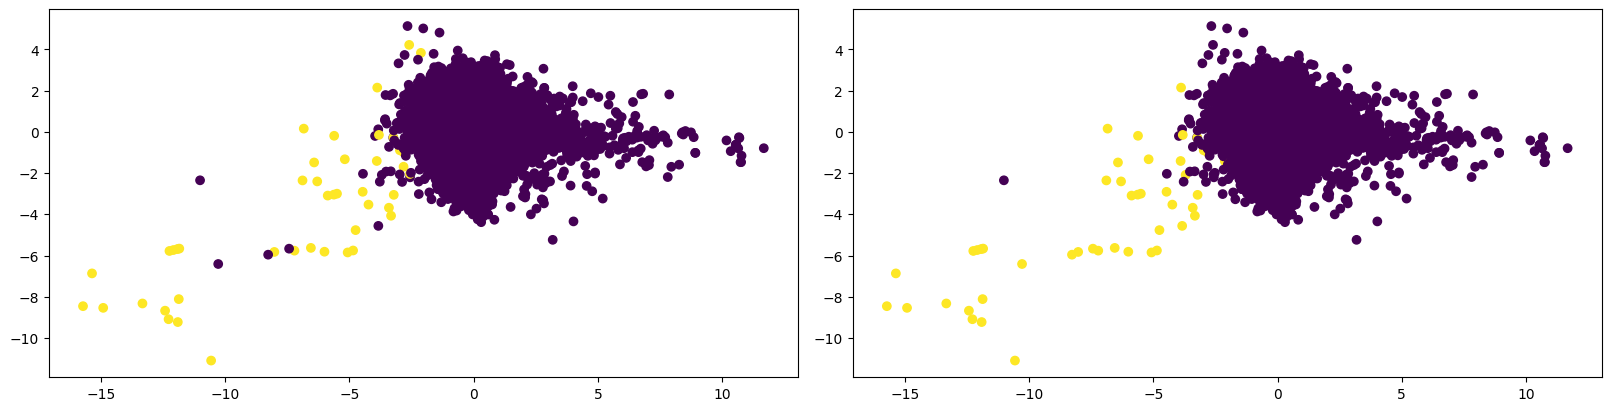

In [45]:
fig, ax = plt.subplots(1,2,figsize=(16,4), layout='constrained')
ax[0].scatter(X_test[:, 10], X_test[:, 18], c = y_test)
ax[1].scatter(X_test[:, 10], X_test[:, 18], c = binary_predictions)

**CNN**

In [46]:
tf.config.run_functions_eagerly(True)

In [47]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten

In [48]:
input_shape = [X_train.shape[1], 1]

In [49]:
cnn = tf.keras.models.Sequential(
    [
        Conv1D(filters=200, kernel_size=3, activation='relu', input_shape=input_shape, strides=2, kernel_initializer='he_uniform'),
        MaxPool1D(pool_size=2, strides=2),
        BatchNormalization(),
        Conv1D(filters=200, kernel_size=3, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        BatchNormalization(),
        Flatten(), 
        Dense(units=512, activation='relu'),
        Dropout(0.2),
        #Dense(units=32, activation='relu',),
        #BatchNormalization(),
        #Dropout(0.2),
        #Dense(units=16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dense(units=1, activation='sigmoid')
    ]
)

In [50]:
cnn.compile(optimizer = Adam(lr=0.001), loss = BinaryCrossentropy(), metrics = ['accuracy'])

In [51]:
cnn.fit(x = X_train, y = y_train,  epochs = 5, batch_size=2000)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


129/129 [==============================] - 10s 71ms/step - loss: 0.0193 - accuracy: 0.9935
Epoch 2/5
129/129 [==============================] - 9s 70ms/step - loss: 0.0052 - accuracy: 0.9992
Epoch 3/5
129/129 [==============================] - 9s 68ms/step - loss: 0.0038 - accuracy: 0.9993
Epoch 4/5
129/129 [==============================] - 9s 69ms/step - loss: 0.0029 - accuracy: 0.9994
Epoch 5/5
129/129 [==============================] - 9s 70ms/step - loss: 0.0026 - accuracy: 0.9994


In [52]:
probabilities = cnn.predict(X_test)

threshold = 0.5

binary_predictions = np.where(probabilities > threshold, 1, 0)


print("Classification Report:")
print(classification_report(y_test, binary_predictions))

891/891 [==============================] - 8s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28426
           1       0.81      0.87      0.84        55

    accuracy                           1.00     28481
   macro avg       0.91      0.94      0.92     28481
weighted avg       1.00      1.00      1.00     28481



In [53]:
average_precision_score(y_test, binary_predictions)

0.7102611862075054

In [54]:
roc_auc_score(y_test, binary_predictions)

0.9361701515258117